In [ ]:
# %%

import numpy as np
import pandas as pd
from nelson_langer_network import build_nelson_network
import time
from astrochem_clustering import AstrochemClusterModel

# Load parameters
datafile = np.load('data/tracer_parameter_data.npy')
datafile[:,0] *= 2
# ['nH', 'T', 'XH2', 'FUV', 'NH', 'zeta'] are the columns of datafile
data = datafile[:,[0, 1, 3]]
# data = datafile[:,[0, 1]]
data[:,[0,1]] = np.log10(data[:,[0,1]])
# data[:,2] /= 8.94e-14
params = pd.DataFrame(data=data, columns=['$\log(n_h)$', '$\log(T)$', '$G_0$'])

# Data for ode solves
# [H_2, H_3^+, e, He, He^+, C, CH_x, O, OH_x, CO, HCO^+, C^+, M^+, M]
#  0    1      2  3   4     5  6     7  8     9   10     11   12   13

# These are the initial conditions used by Nina in her testing code
x0 = np.array([
    0.5,
    9.059e-9,
    2e-4,
    0.1,
    7.866e-7,
    0.0,
    0.0,
    0.0004,
    0.0,
    0.0,
    0.0,
    0.0002,
    2.0e-7,
    2.0e-7
])
# From the overleaf doc
# x0 = np.array([
    # what should go here anyways?
# ])

secs_per_year = 3600*24*365
tf = 10000 * secs_per_year


def solve_nelson_network(params_row: np.ndarray, x0: np.ndarray, QoI: np.ndarray, time: float):
    n_h = 10**params_row[0]
    T = 10**params_row[1]
    G0 = params_row[2]
    network = build_nelson_network(n_h = n_h, T = T, G0 = G0)
    tvec, yvec = network.solve_reaction([0, time], x0)
    return yvec[QoI, -1]

In [ ]:
# %% Load data

foo = np.load('data/small_dataset.npy')
small_dataset = pd.DataFrame(data=foo, columns=['$\log(n_h)$', '$\log(T)$', '$G_0$'])

np.random.seed(1234)
msk = np.random.rand(len(small_dataset)) > 0.2
train = small_dataset[msk]
test = small_dataset[~msk]

In [ ]:
# %% Train model

start_time = time.perf_counter()
surrogate = AstrochemClusterModel()
N_clusters = surrogate.train_surrogate_model(train.reset_index(drop=True), 0.05, [2, 0, 1, 9, 5], x0, tf, 10, 10)
end_time = time.perf_counter()
print(f'Number of clusters: {N_clusters}')

total_time = end_time - start_time # in seconds
print(f'Training time: {total_time:.2f} seconds')

Number of clusters: 2485
Training time: 1324.45 seconds


In [ ]:
# %% Test Model

start_time = time.perf_counter()
datamat = np.zeros(shape=(len(test),19))
# Exact solution for e, H2, H3+, CO, C in columns 0-4
# Index in column 5
# Predictions in columns 6-10
# Errors in columns 11-15
# Test data in columns 16-18
for index, row in test.reset_index(drop=True).iterrows():
    datamat[index, [0,1,2,3,4]] = solve_nelson_network(row.to_numpy(), x0, [2,0,1,9,5], tf)
mid_time = time.perf_counter()
datamat[:,[5,6,7,8,9,10]] = surrogate.predict(test.to_numpy())
end_time = time.perf_counter()
print(f'Time to solve all ODEs: {mid_time-start_time} seconds')
print(f'Time to predict data: {end_time-mid_time}')
datamat[:,[11,12,13,14,15]] = np.abs(datamat[:,[6,7,8,9,10]] - datamat[:,[0,1,2,3,4]]) / np.abs(datamat[:,[0,1,2,3,4]])
datamat[:,[16,17,18]] = test.to_numpy()

Time to solve all ODEs: 197.85473737493157 seconds
Time to predict data: 0.004168790997937322


In [ ]:
# %% Error statistics

ind = 11
print(f'Mean: {np.mean(datamat[:,ind])}')
print(f'Median: {np.median(datamat[:,ind])}')
print(f'Max: {np.max(datamat[:,ind])}')
print(f'STD: {np.std(datamat[:,ind])}')
num_vals_outside_error = (datamat[:,ind] > 0.05).sum()
print(f'# of points outside error: {num_vals_outside_error} ({num_vals_outside_error/len(datamat[:,2])}% of data)')

Mean: 0.00030514063539893363
Median: 0.0002600045841084207
Max: 0.006003671402374352
STD: 0.00024866926496402373
# of points outside error: 0 (0.0% of data)


In [ ]:
# %% Error statistics

ind = 12
print(f'Mean: {np.mean(datamat[:,ind])}')
print(f'Median: {np.median(datamat[:,ind])}')
print(f'Max: {np.max(datamat[:,ind])}')
print(f'STD: {np.std(datamat[:,ind])}')
num_vals_outside_error = (datamat[:,ind] > 0.05).sum()
print(f'# of points outside error: {num_vals_outside_error} ({num_vals_outside_error/len(datamat[:,2])}% of data)')

Mean: 4.1219431448691087e-10
Median: 3.4052690373469276e-10
Max: 7.403195040491844e-09
STD: 3.520552805912369e-10
# of points outside error: 0 (0.0% of data)


In [ ]:
# %% Error statistics

ind = 13
print(f'Mean: {np.mean(datamat[:,ind])}')
print(f'Median: {np.median(datamat[:,ind])}')
print(f'Max: {np.max(datamat[:,ind])}')
print(f'STD: {np.std(datamat[:,ind])}')
num_vals_outside_error = (datamat[:,ind] > 0.05).sum()
print(f'# of points outside error: {num_vals_outside_error} ({num_vals_outside_error/len(datamat[:,2])}% of data)')

Mean: 0.011050840220056968
Median: 0.009830602609141145
Max: 0.1584214796595432
STD: 0.008104591146235334
# of points outside error: 6 (0.0009578544061302681% of data)


In [ ]:
# %% Error statistics

ind = 14
print(f'Mean: {np.mean(datamat[:,ind])}')
print(f'Median: {np.median(datamat[:,ind])}')
print(f'Max: {np.max(datamat[:,ind])}')
print(f'STD: {np.std(datamat[:,ind])}')
num_vals_outside_error = (datamat[:,ind] > 0.05).sum()
print(f'# of points outside error: {num_vals_outside_error} ({num_vals_outside_error/len(datamat[:,2])}% of data)')

Mean: 0.01982479619660839
Median: 0.017586168103091174
Max: 0.2075647502911587
STD: 0.01460503254346692
# of points outside error: 181 (0.028895274584929756% of data)


In [ ]:
# %% Error statistics

ind = 15
print(f'Mean: {np.mean(datamat[:,ind])}')
print(f'Median: {np.median(datamat[:,ind])}')
print(f'Max: {np.max(datamat[:,ind])}')
print(f'STD: {np.std(datamat[:,ind])}')
num_vals_outside_error = (datamat[:,ind] > 0.05).sum()
print(f'# of points outside error: {num_vals_outside_error} ({num_vals_outside_error/len(datamat[:,2])}% of data)')

Mean: 0.01119589981121826
Median: 0.009821162315335781
Max: 0.13793539440226943
STD: 0.00812142310756043
# of points outside error: 6 (0.0009578544061302681% of data)


(array([3.174e+03, 2.228e+03, 7.430e+02, 9.700e+01, 1.600e+01, 2.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29]),
 <BarContainer object of 29 artists>)

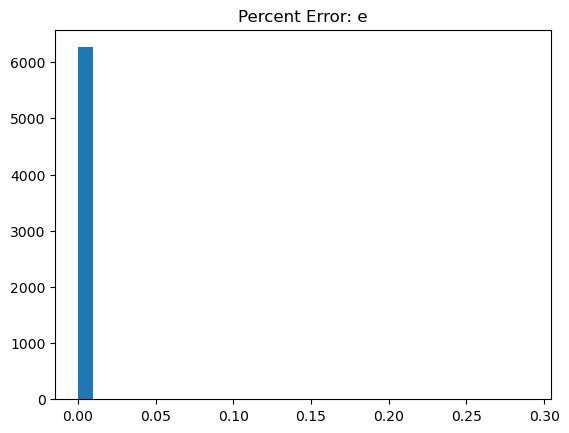

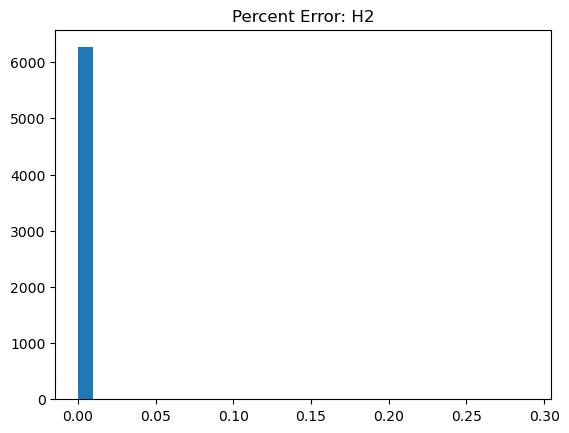

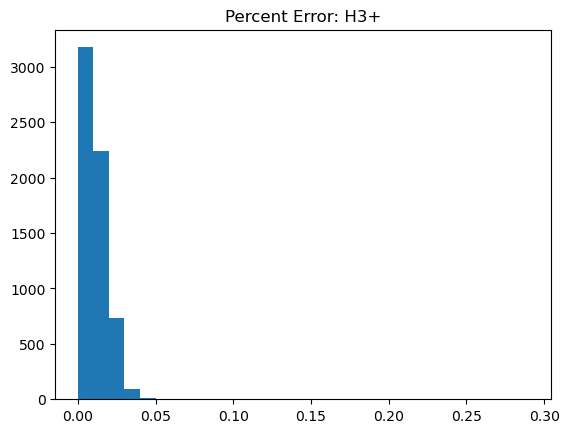

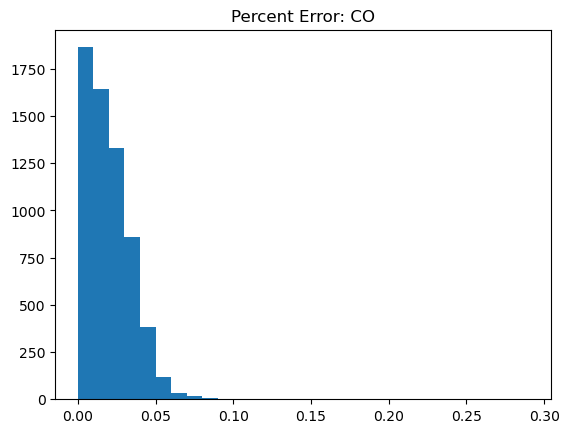

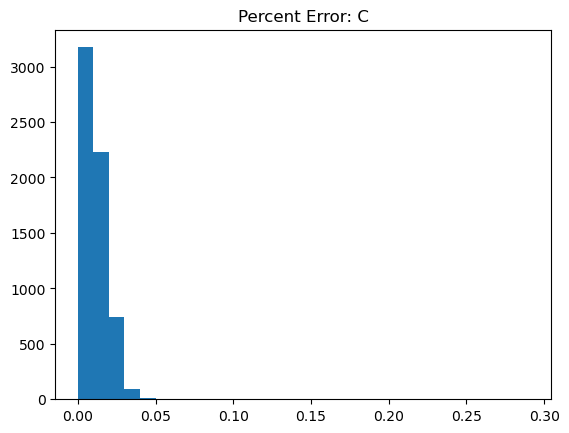

In [ ]:
# %%

import matplotlib.pyplot as plt
plt.figure()
plt.title('Percent Error: e')
plt.hist(datamat[:,11], bins=np.arange(0, 0.3, 0.01))
plt.figure()
plt.title('Percent Error: H2')
plt.hist(datamat[:,12], bins=np.arange(0, 0.3, 0.01))
plt.figure()
plt.title('Percent Error: H3+')
plt.hist(datamat[:,13], bins=np.arange(0, 0.3, 0.01))
plt.figure()
plt.title('Percent Error: CO')
plt.hist(datamat[:,14], bins=np.arange(0, 0.3, 0.01))
plt.figure()
plt.title('Percent Error: C')
plt.hist(datamat[:,15], bins=np.arange(0, 0.3, 0.01))